8982
1000
7982
Train on 7982 samples, validate on 1000 samples
Epoch 1/100
7982/7982 [==============================] - 2s 240us/step - loss: 3.0400 - acc: 0.6232 - val_loss: 2.1025 - val_acc: 0.6900
Epoch 2/100
7982/7982 [==============================] - 1s 134us/step - loss: 2.0336 - acc: 0.7370 - val_loss: 1.6492 - val_acc: 0.7020
Epoch 3/100
7982/7982 [==============================] - 1s 136us/step - loss: 1.4599 - acc: 0.7839 - val_loss: 1.4062 - val_acc: 0.7310
Epoch 4/100
7982/7982 [==============================] - 1s 136us/step - loss: 1.0782 - acc: 0.8312 - val_loss: 1.3083 - val_acc: 0.7440
Epoch 5/100
7982/7982 [==============================] - 1s 138us/step - loss: 0.8130 - acc: 0.8667 - val_loss: 1.1857 - val_acc: 0.7610
Epoch 6/100
7982/7982 [==============================] - 1s 136us/step - loss: 0.6197 - acc: 0.8988 - val_loss: 1.1918 - val_acc: 0.7710
Epoch 7/100
7982/7982 [==============================] - 1s 138us/step - loss: 0.4665 - acc: 0.9218 - val_loss: 1.1

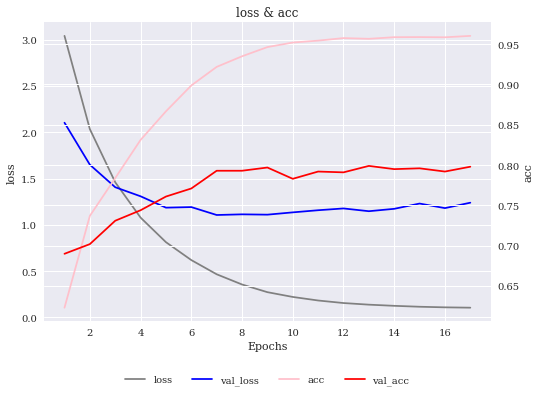

In [7]:
# %%
from keras.datasets import reuters
from keras import models
from keras import regularizers
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)
def vectorize_sequence(sequence, dimension= 15000):
    results = np.zeros((len(sequence), dimension))      # (len(sequence), dimension) の零行列
    for i, sequence in enumerate(sequence):     # results[i]のインデックスを1に設定
        results[i, sequence] = 1.
    return results

'''
データの設定
'''
# data:レビューのリスト(単語のシーケンスをエンコード済み)
# labels: 0で「否定的」、1で「肯定的」
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=15000)      # 出現率の高い上位10000語を選択

x_train = vectorize_sequence(train_data)        # 訓練データのベクトル化
x_test = vectorize_sequence(test_data)          # テストデータのベクトル化
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

val_size = 1000

x_val = x_train[:val_size]
partial_x_train = x_train[val_size:]
y_val = y_train[:val_size]
partial_y_train = y_train[val_size:]

print(len(x_train))
print(len(x_val))
print(len(partial_x_train))


'''
モデルの構築
'''
def weight_variable(shape):
    return K.truncated_normal(shape, stddev=0.01)
n_in = len(x_train)
n_out = 46
n_hiddens = [64]
# p_keep = 0.4
early_stopping = EarlyStopping(monitor= "val_loss", patience= 10, verbose= 1)

model = models.Sequential()
model.add(Dense(64, kernel_initializer= weight_variable, activation='relu'))
model.add(BatchNormalization())
for i, input_shape in enumerate(([n_in]+n_hiddens)[:-1]):
    model.add(Dense(n_hiddens[i], kernel_initializer=weight_variable, activation="relu"))
    model.add(BatchNormalization())
#     model.add(Dropout(p_keep))
model.add(Dense(n_out, kernel_initializer= weight_variable, activation= "softmax"))

model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

'''
モデル学習
'''
history = model.fit(partial_x_train,partial_y_train,epochs=100,batch_size=512,validation_data=(x_val, y_val), callbacks= [early_stopping])

'''
予測精度の評価
'''
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

epochs = range(1, len(loss_values) + 1)
plt.rc('font', family='serif')
fig = plt.figure()
ax_loss = fig.add_subplot(111)
g1 = ax_loss.plot(epochs, loss_values, label='loss', color='gray')
g2 = ax_loss.plot(epochs, val_loss_values, label= "val_loss", color="blue")
ax_acc = ax_loss.twinx()
g3 = ax_acc.plot(epochs, acc_values, label='acc', color='pink')
g4 = ax_acc.plot(epochs, val_acc_values, label='val_acc', color='red')
plt.title("loss & acc")

h1, l1 = ax_loss.get_legend_handles_labels()
h2, l2 = ax_acc.get_legend_handles_labels()
ax_loss.legend(h1+h2, l1+l2, loc='upper center',bbox_to_anchor=(0.5,-0.15),ncol=4)

ax_loss.set_xlabel("Epochs")
ax_loss.set_ylabel("loss")
ax_loss.grid(True)
ax_acc.set_ylabel("acc")
plt.show()
